In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.basics import *
import json
from tqdm import tqdm

import jkbc.model as m
import jkbc.model.factory as factory
import jkbc.constants as constants
import jkbc.files.torch_files as f
import jkbc.model.metrics as metric
import jkbc.utils.preprocessing as prep
import jkbc.utils.postprocessing as pop
import jkbc.files.fasta as fasta

## Constants

### Data

In [3]:
BASE_DIR = Path("../..")
PATH_DATA = 'data/feather-files'
DATA_SET = 'Range0-50-FixLabelLen400-winsize4096'
FEATHER_FOLDER = BASE_DIR/PATH_DATA/DATA_SET

with open(FEATHER_FOLDER/'config.json', 'r') as fp:
    config = json.load(fp)

ALPHABET       = constants.ALPHABET
ALPHABET_VAL   = list(ALPHABET.values())
ALPHABET_STR   = ''.join(ALPHABET_VAL)
ALPHABET_SIZE  = len(ALPHABET.keys())
WINDOW_SIZE    = int(config['maxw']) #maxw = max windowsize
DIMENSIONS_OUT = int(config['maxl']) # maxl = max label length

KNOWLEGDE_DISTILLATION = True
TEACHER_OUTPUT = 'bonito-csv' # Set to name of y_teacher output
if KNOWLEGDE_DISTILLATION and not TEACHER_OUTPUT:
    print('WARNING! Must provide name of teacher output when doing knowledge distillation')

### Train/Predict

In [4]:
LR = 1e-3  # default learning rate
BS = 2**7  # batch size
EPOCHS = 400
DEVICE = m.get_available_gpu() #torch.device("cpu")
DEVICE

device(type='cuda', index=3)

### Model

In [5]:
DROP_LAST = False # SET TO TRUE IF IT FAILS ON LAST BATCH
model, (MODEL_NAME, pred_dim_out) = factory.bonito(WINDOW_SIZE, DEVICE, BASE_DIR)
MODEL_NAME = f'{MODEL_NAME}-student'
MODEL_DIR = f'{MODEL_NAME}/weights'
model_weights = None#'bestmodel_8'

In [6]:
# Run to get newest model
if not model_weights:
    model_weights = m.get_newest_model(MODEL_DIR)
print(model_weights)

bestmodel_3


### Loss, metrics and callback

In [7]:
_ctc_loss = metric.CtcLoss(WINDOW_SIZE, pred_dim_out, BS, ALPHABET_SIZE)
_kd_loss = metric.KdLoss(alpha=.05, temperature=20, label_loss=_ctc_loss)
LOSS_FUNC = _kd_loss.loss() if KNOWLEGDE_DISTILLATION else _ctc_loss.loss()

METRICS = [metric.ctc_accuracy(ALPHABET, 5)]
SAVE_CALLBACK = partial(metric.SaveModelCallback, every='epoch', monitor='ctc_accuracy')

## Load data

In [8]:
# Read data from feather
if KNOWLEGDE_DISTILLATION:
    data, teacher = f.load_training_data_with_teacher(FEATHER_FOLDER, TEACHER_OUTPUT)
    train_dl, valid_dl = prep.convert_to_dataloaders(data, split=.8, batch_size=BS, teacher=teacher, drop_last=DROP_LAST)
else:
    data = f.load_training_data(FEATHER_FOLDER) 
    train_dl, valid_dl = prep.convert_to_dataloaders(data, split=.8, batch_size=BS, drop_last=DROP_LAST)

# Convert to databunch
databunch = DataBunch(train_dl, valid_dl, device=DEVICE)

## Model

In [9]:
optimizer = partial(torch.optim.AdamW, amsgrad=True, lr=LR)

In [10]:
learner = Learner(databunch, model, loss_func=LOSS_FUNC, model_dir=MODEL_DIR, metrics=METRICS, opt_func=optimizer).to_fp16()

In [11]:
try:
    learner.load(model_weights)
    print(f'{model_weights} loaded')
except:
    print(f'No model could be found')

bestmodel_3 loaded


## Train

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 2.51E-04


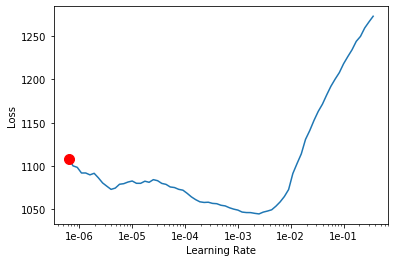

In [12]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

In [15]:
# Default to LR if lr_find() has not been run
try: lr = learner.recorder.min_grad_lr
except: lr = LR
lr 

0.001

In [16]:
learner.fit(EPOCHS, lr=lr, callbacks=[SAVE_CALLBACK(learner), metric.CSVLogger(learner, filename=f'{MODEL_NAME}/history', append=True)])

epoch,train_loss,valid_loss,ctc_accuracy,time
0,1059.007812,1117.983521,0.627808,00:22
1,983.392761,1091.016968,0.638220,00:22
2,898.085327,1089.058105,0.656017,00:22
3,823.248291,1185.195312,0.645719,00:22


KeyboardInterrupt: 

In [ ]:
learner.recorder.plot_losses()